# Lotto 5/35

In [49]:
import time
from datetime import datetime
from typing import List, Optional, Tuple
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools

from selenium import webdriver
from selenium.webdriver.chromium.webdriver import ChromiumDriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait, Select
from selenium.webdriver.support import expected_conditions as EC

from bs4 import BeautifulSoup, Tag

## Parameters

## Import libraries

In [2]:
URL = "https://www.minhchinh.com/thong-ke-lotto-535.html"
FROM_DATE = "01-01-2024"  # dd-MM-yyyy
TO_DATE = datetime.now().strftime("%d-%m-%Y")  # dd-MM-yyyy
FROM_DATE, TO_DATE

('01-01-2024', '20-02-2026')

In [3]:
LOTTO_5_35_FILE_NAME = "lotto_5_35"
LOTTO_5_35_CLEANED_FILE_NAME = "lotto_5_35_cleaned"

In [4]:
SCRAPER_BASE_WAIT_TIME = 1

## Helper functions

In [5]:
def update_bs4_parser(web_driver: ChromiumDriver) -> BeautifulSoup:
    return BeautifulSoup(web_driver.page_source, "html.parser")

In [6]:
def navigate_to_url(
    web_driver: ChromiumDriver, url: str
) -> Tuple[ChromiumDriver, BeautifulSoup]:
    print(f'Navigating to URL: "{url}"')
    web_driver.get(url)
    time.sleep(SCRAPER_BASE_WAIT_TIME)
    bs4_parser = update_bs4_parser(web_driver)

    return (web_driver, bs4_parser)

In [7]:
def input_text(web_driver: ChromiumDriver, xpath: str, value: str) -> None:
    input_element = WebDriverWait(web_driver, 10).until(
        EC.element_to_be_clickable((By.XPATH, xpath))
    )
    input_element.clear()
    input_element.send_keys(value)

In [8]:
def click_element(web_driver: ChromiumDriver, xpath: str) -> None:
    element = WebDriverWait(web_driver, 10).until(
        EC.element_to_be_clickable((By.XPATH, xpath))
    )
    element.click()

In [9]:
def extract_table(table: Optional[Tag]):
    # Extract headers
    headers = []
    thead = table.find("thead")
    if thead:
        header_row = thead.find_all("tr")[-1]  # use the last row if rowspan is present
        headers = [th.get_text(strip=True) for th in header_row.find_all("th")]

    # Extract rows
    rows = []
    tbody = table.find("tbody")
    for tr in tbody.find_all("tr"):
        # Skip group title rows
        if tr.get("class") and "group" in tr.get("class"):
            continue
        row = []
        for td in tr.find_all(["td"]):
            text = td.get_text(strip=True)
            row.append(text)
        rows.append(row)

    return (headers, rows)


def extract_table_by_class(
    bs4_parser: BeautifulSoup, class_name: str
) -> Tuple[List, List]:
    table = bs4_parser.find("table", class_=class_name)
    return extract_table(table)

## Start

### Scrape data from web

In [10]:
chrome_options = Options()
chrome_options.add_experimental_option(
    "prefs",
    {
        "profile.managed_default_content_settings.images": 2,  # Disable images
        "profile.managed_default_content_settings.stylesheets": 2,  # Disable CSS
        "profile.managed_default_content_settings.javascript": 1,  # Keep JS if needed
    },
)
chrome_options.add_argument(
    "user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36"
)

In [11]:
web_driver: ChromiumDriver = webdriver.Chrome(options=chrome_options)
bs4_parser: BeautifulSoup = BeautifulSoup(web_driver.page_source, "html.parser")
web_driver.maximize_window()

In [12]:
navigate_to_url(web_driver, URL)

from_date_xpath = '//*[@id="dateFromId"]'
to_date_xpath = '//*[@id="dateToId"]'
submit_button_xpath = '//*[@id="noidung"]/div[2]/div/div[1]/div/button'

click_element(web_driver, from_date_xpath)
input_text(web_driver, from_date_xpath, FROM_DATE)

click_element(web_driver, to_date_xpath)
input_text(web_driver, to_date_xpath, TO_DATE)

click_element(web_driver, submit_button_xpath)

time.sleep(SCRAPER_BASE_WAIT_TIME * 2)

bs4_parser = update_bs4_parser(web_driver)

Navigating to URL: "https://www.minhchinh.com/thong-ke-lotto-535.html"


In [13]:
table_class_name = "table-mini-result"

raw_table = extract_table_by_class(bs4_parser, table_class_name)

if len(raw_table):
    with open(
        f"{LOTTO_5_35_FILE_NAME}.csv", "w", newline="\n", encoding="utf-8"
    ) as file:
        writer = csv.writer(file)
        writer.writerows([raw_table[0]])
        writer.writerows(raw_table[1])

print(f"Data has been saved to '{LOTTO_5_35_FILE_NAME}.csv'")

web_driver.close()

Data has been saved to 'lotto_5_35.csv'


### Preprocess data

In [14]:
pandas_df = pd.read_csv(f"{LOTTO_5_35_FILE_NAME}.csv", dtype=str)

# Extract date and hour
pandas_df["date"] = pandas_df["NgàyMở Thưởng"].str.split().str[0]
pandas_df["hour"] = (
    pandas_df["NgàyMở Thưởng"].str.split().str[1].str.replace("h", "", regex=False)
)

# Split 12-digit result into 6 two-digit numbers
for i in range(6):
    col_name = f"x_{i+1}" if i < 5 else "x_s"
    pandas_df[col_name] = pandas_df["Kết Quả"].str[i * 2 : (i + 1) * 2]

# Clean prize (remove commas)
pandas_df["prize"] = pandas_df["Độc Đắc"].str.replace(",", "", regex=False)

# Keep only new columns
pandas_df = pandas_df[
    ["date", "hour", "x_1", "x_2", "x_3", "x_4", "x_5", "x_s", "prize"]
]

pandas_df

,date,hour,x_1,x_2,x_3,x_4,x_5,x_s,prize
0,20/02/26,13,10,12,27,30,31,12,6727910000
1,19/02/26,21,09,21,23,25,29,03,6569592500
2,19/02/26,13,01,13,14,19,30,01,6438642500
3,18/02/26,21,09,23,27,29,33,01,6248570000
4,18/02/26,13,11,17,25,30,32,06,6085047500
...,...,...,...,...,...,...,...,...,...
468,01/07/25,13,01,18,25,27,33,05,6676525000
469,30/06/25,21,01,12,13,27,28,07,6518352500
470,30/06/25,13,02,08,16,23,24,09,6315905000
471,29/06/25,21,06,12,14,18,25,08,6231295000


In [15]:
pandas_df.to_csv(f"{LOTTO_5_35_CLEANED_FILE_NAME}.csv", index=False)

### Analyze data

In [16]:
cleaned_df = pd.read_csv(f"{LOTTO_5_35_CLEANED_FILE_NAME}.csv")
cleaned_df

,date,hour,x_1,x_2,x_3,x_4,x_5,x_s,prize
0,20/02/26,13,10,12,27,30,31,12,6727910000
1,19/02/26,21,9,21,23,25,29,3,6569592500
2,19/02/26,13,1,13,14,19,30,1,6438642500
3,18/02/26,21,9,23,27,29,33,1,6248570000
4,18/02/26,13,11,17,25,30,32,6,6085047500
...,...,...,...,...,...,...,...,...,...
468,01/07/25,13,1,18,25,27,33,5,6676525000
469,30/06/25,21,1,12,13,27,28,7,6518352500
470,30/06/25,13,2,8,16,23,24,9,6315905000
471,29/06/25,21,6,12,14,18,25,8,6231295000


In [17]:
def make_centered_bins(min_value, n_bins, column_width):
    start = min_value - column_width / 2
    end = min_value + n_bins - 1 + column_width / 2
    return np.arange(start, end + column_width, column_width)


def plot_histograms(cleaned_df, column_width=0.5, mode="percentage"):
    """
    Plots histograms for predefined columns in cleaned_df.

    Parameters:
    - cleaned_df (pd.DataFrame): DataFrame containing the data
    - column_width (float): Width of histogram bins
    - mode (str): "percentage" or "count"
    """

    if mode not in ["percentage", "count"]:
        raise ValueError("mode must be 'percentage' or 'count'")

    columns = ["x_1", "x_2", "x_3", "x_4", "x_5", "x_s"]

    fig, axes = plt.subplots(3, 2, figsize=(30, 15), sharex=False)
    axes = axes.flatten()

    for i, col in enumerate(columns):

        if col not in cleaned_df.columns:
            raise ValueError(f"Column '{col}' not found in DataFrame")

        data = cleaned_df[col].astype(int)

        # Choose bin range
        if col == "x_s":
            bins = make_centered_bins(1, 12, column_width)
            xticks = range(1, 13)
        else:
            bins = make_centered_bins(1, 35, column_width)
            xticks = range(1, 36)

        # Apply weights only if percentage mode
        if mode == "percentage":
            weights = np.ones_like(data) * 100.0 / len(data)
            axes[i].hist(data, bins=bins, weights=weights)
            axes[i].set_ylabel("Percentage (%)")
        else:
            axes[i].hist(data, bins=bins)
            axes[i].set_ylabel("Count")

        axes[i].set_xticks(xticks)
        axes[i].set_title(col)
        axes[i].tick_params(axis="x", bottom=True, labelbottom=True)

    plt.tight_layout()
    plt.show()


def extended_summary(series):
    summary = {
        "Count": series.count(),
        "Mean": series.mean(),
        "Median": series.median(),
        "Mode": series.mode().iloc[0] if not series.mode().empty else None,
        "Std Dev": series.std(),
        "Variance": series.var(),
        "Min": series.min(),
        "Max": series.max(),
        "Skewness": series.skew(),
        "Kurtosis": series.kurt(),
        "Unique Values": series.nunique(),
    }

    return pd.DataFrame(summary, index=[series.name]).T

In [18]:
# Plot config
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (14, 6)
column_width = 0.5

In [20]:
cleaned_df

,date,hour,x_1,x_2,x_3,x_4,x_5,x_s,prize
0,20/02/26,13,10,12,27,30,31,12,6727910000
1,19/02/26,21,9,21,23,25,29,3,6569592500
2,19/02/26,13,1,13,14,19,30,1,6438642500
3,18/02/26,21,9,23,27,29,33,1,6248570000
4,18/02/26,13,11,17,25,30,32,6,6085047500
...,...,...,...,...,...,...,...,...,...
468,01/07/25,13,1,18,25,27,33,5,6676525000
469,30/06/25,21,1,12,13,27,28,7,6518352500
470,30/06/25,13,2,8,16,23,24,9,6315905000
471,29/06/25,21,6,12,14,18,25,8,6231295000


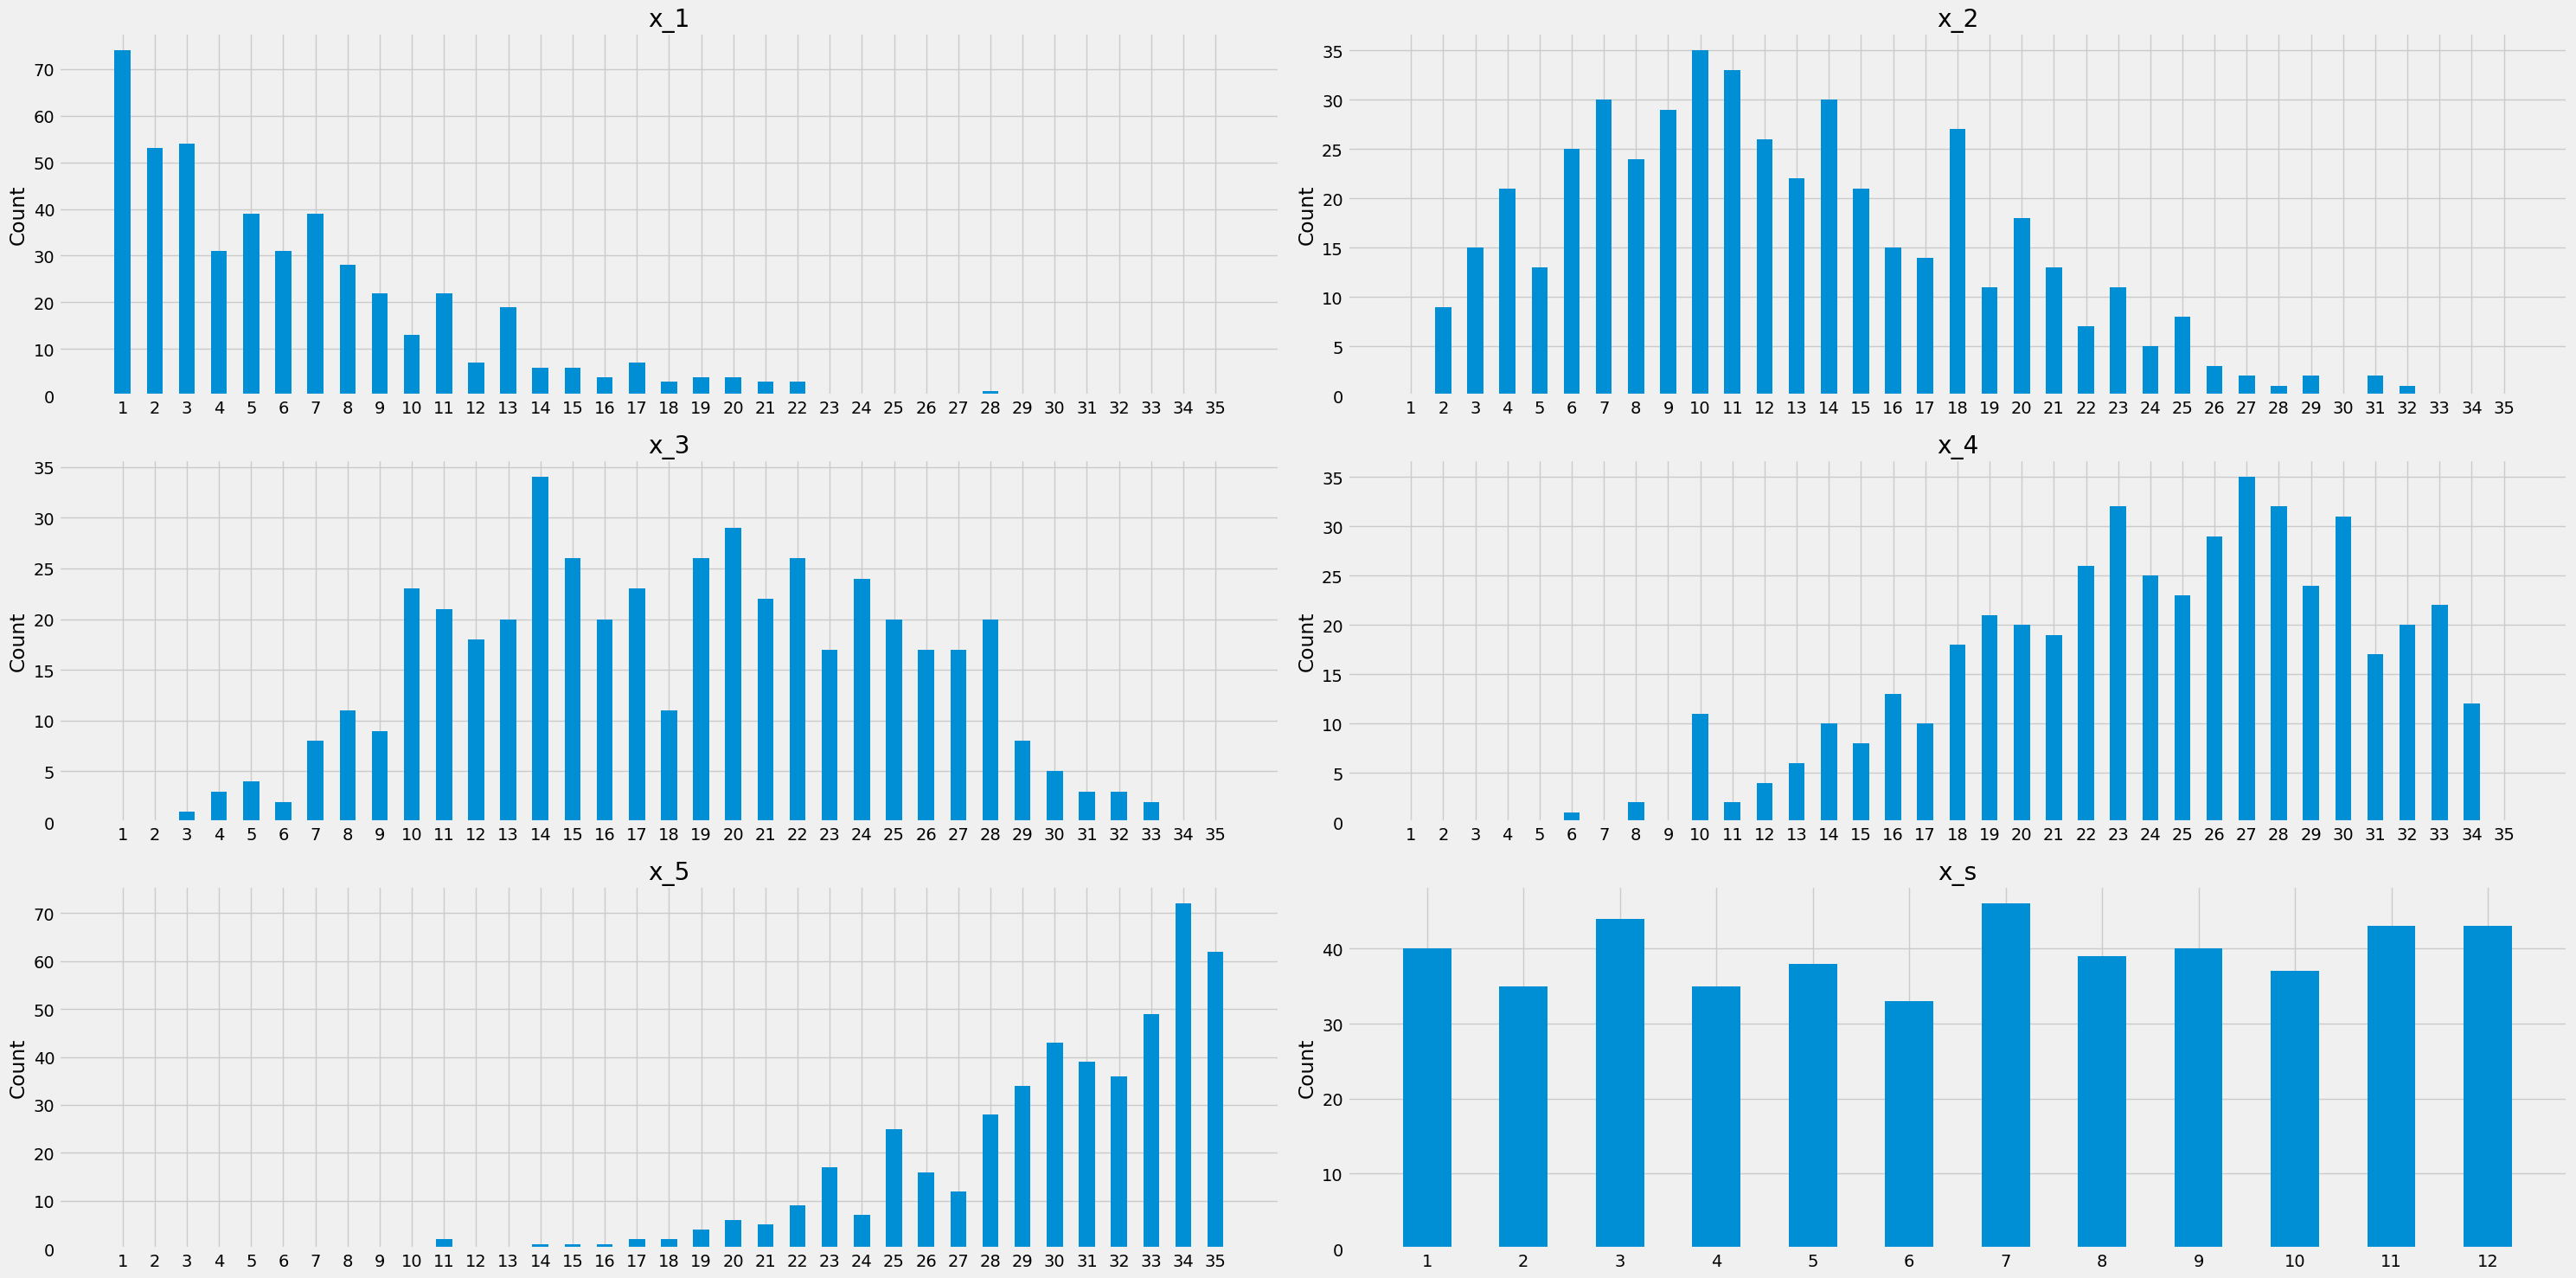

In [34]:
plot_histograms(cleaned_df, mode="count")

In [56]:
extended_summary(cleaned_df["x_1"])

,x_1
Count,473.000000
Mean,6.276956
Median,5.000000
Mode,1.000000
Std Dev,4.943905
Variance,24.442201
Min,1.000000
Max,28.000000
Skewness,1.184209
Kurtosis,1.212658


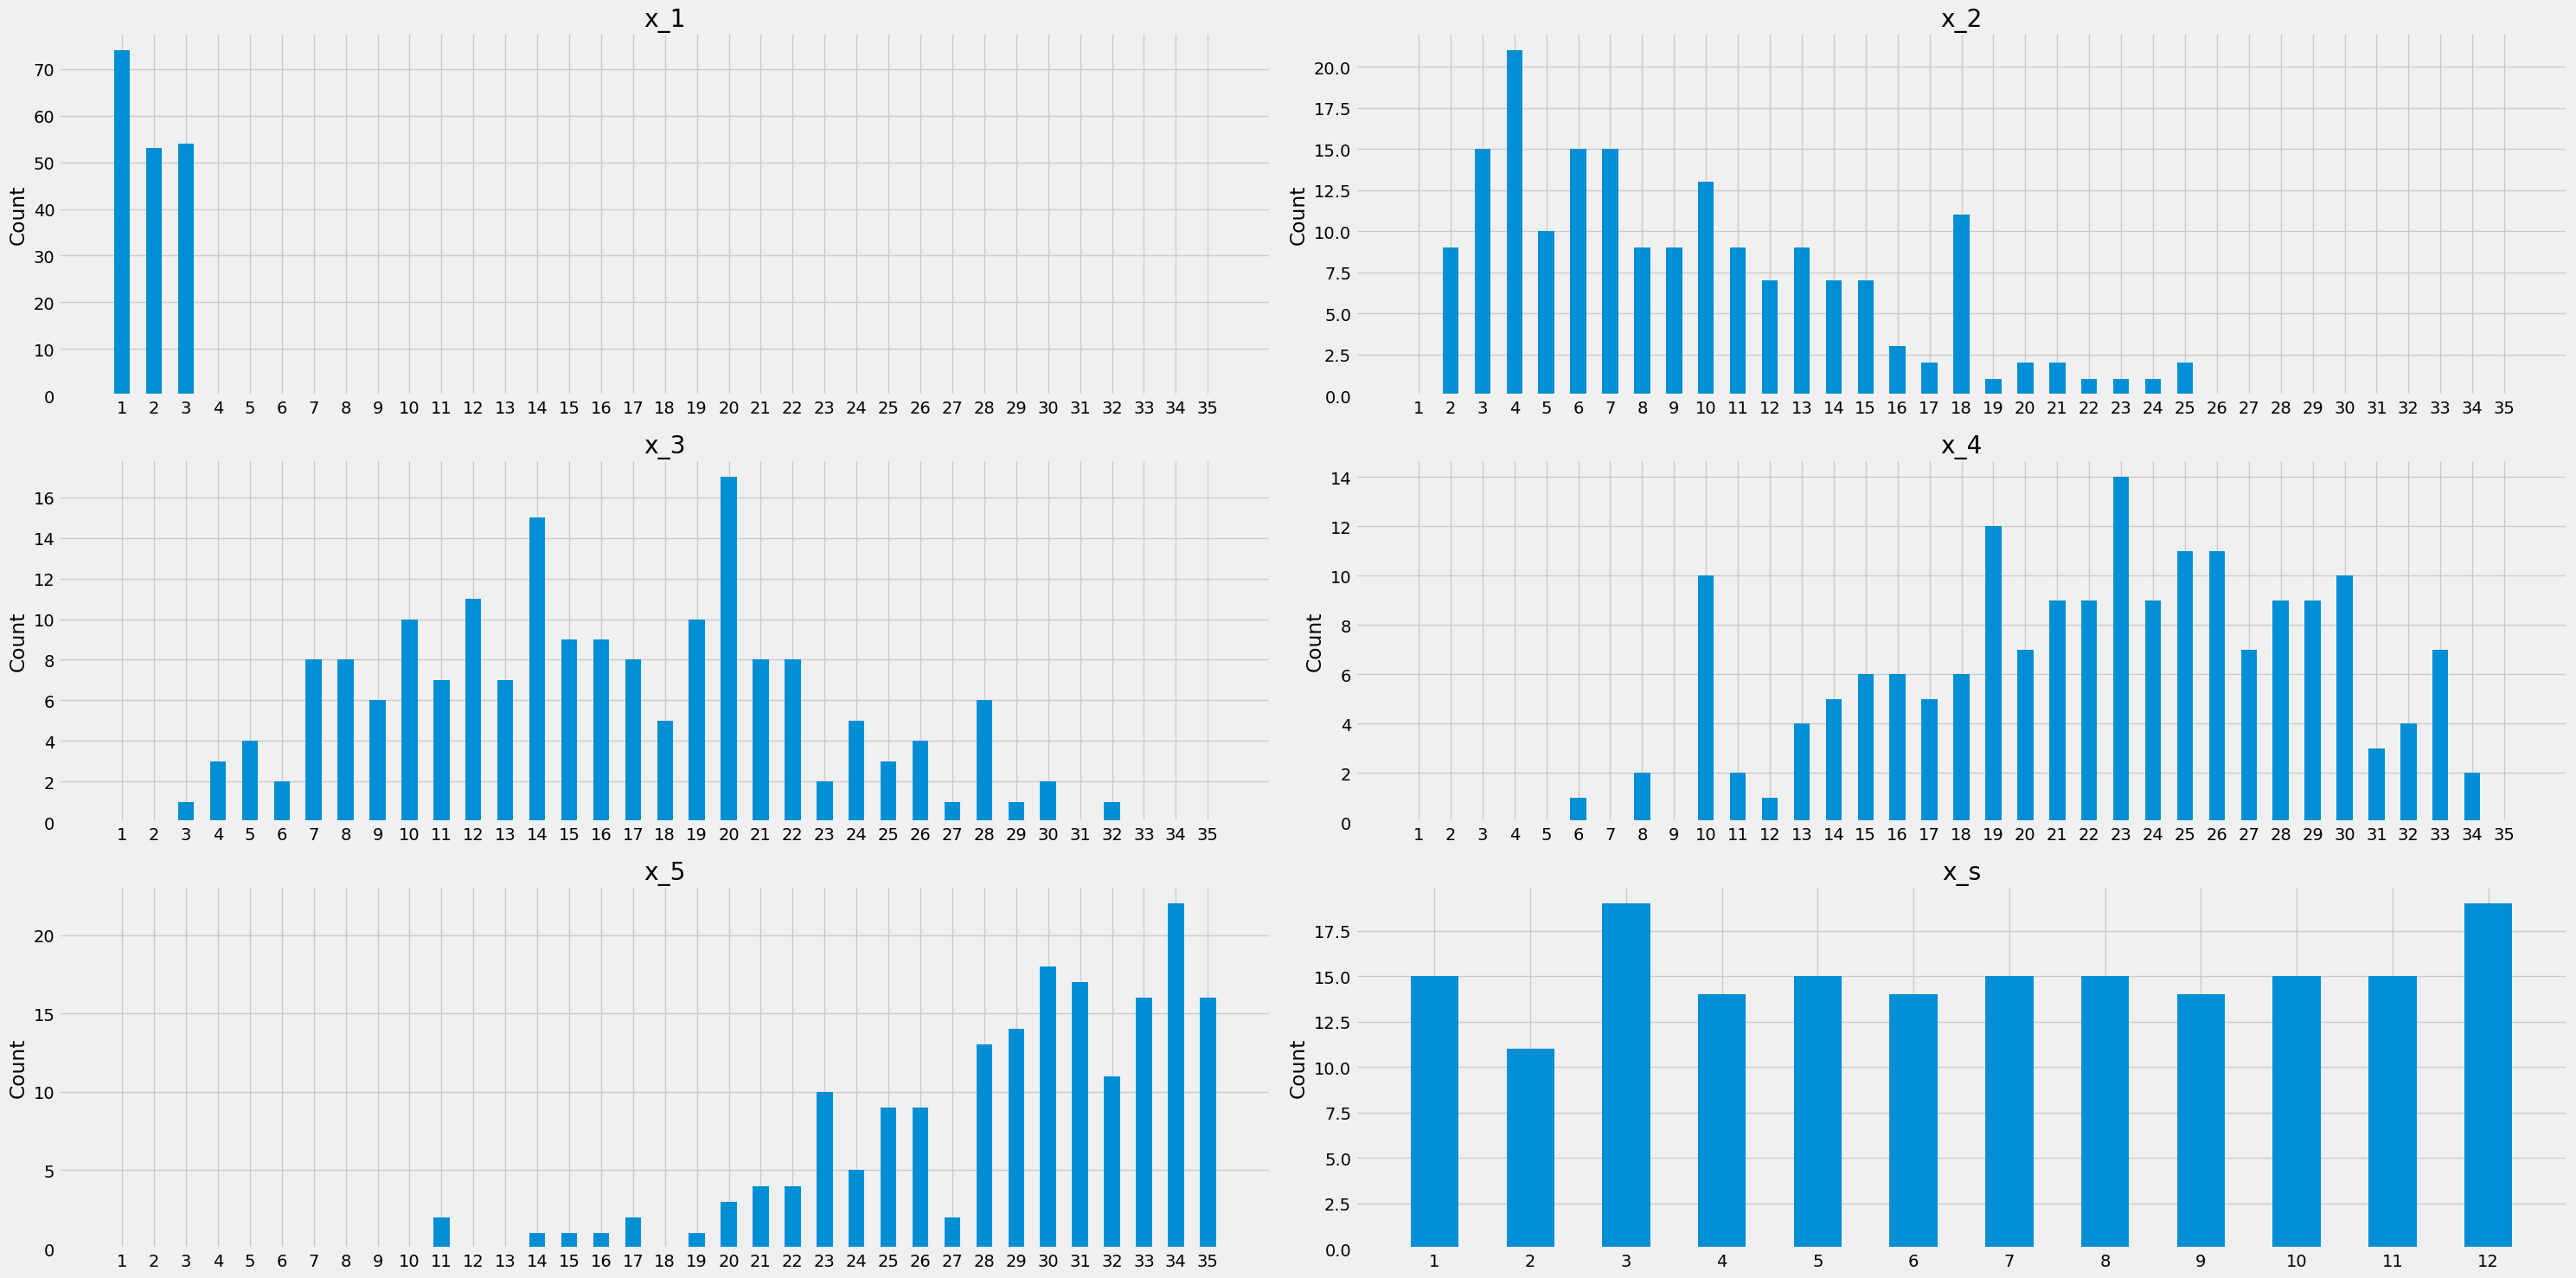

In [55]:
filter_1 = cleaned_df[cleaned_df["x_1"].isin(range(1, 4))]

plot_histograms(filter_1, mode="count")

In [57]:
extended_summary(filter_1["x_2"])

,x_2
Count,181.000000
Mean,9.270718
Median,8.000000
Mode,4.000000
Std Dev,5.496329
Variance,30.209638
Min,2.000000
Max,25.000000
Skewness,0.757481
Kurtosis,-0.123845


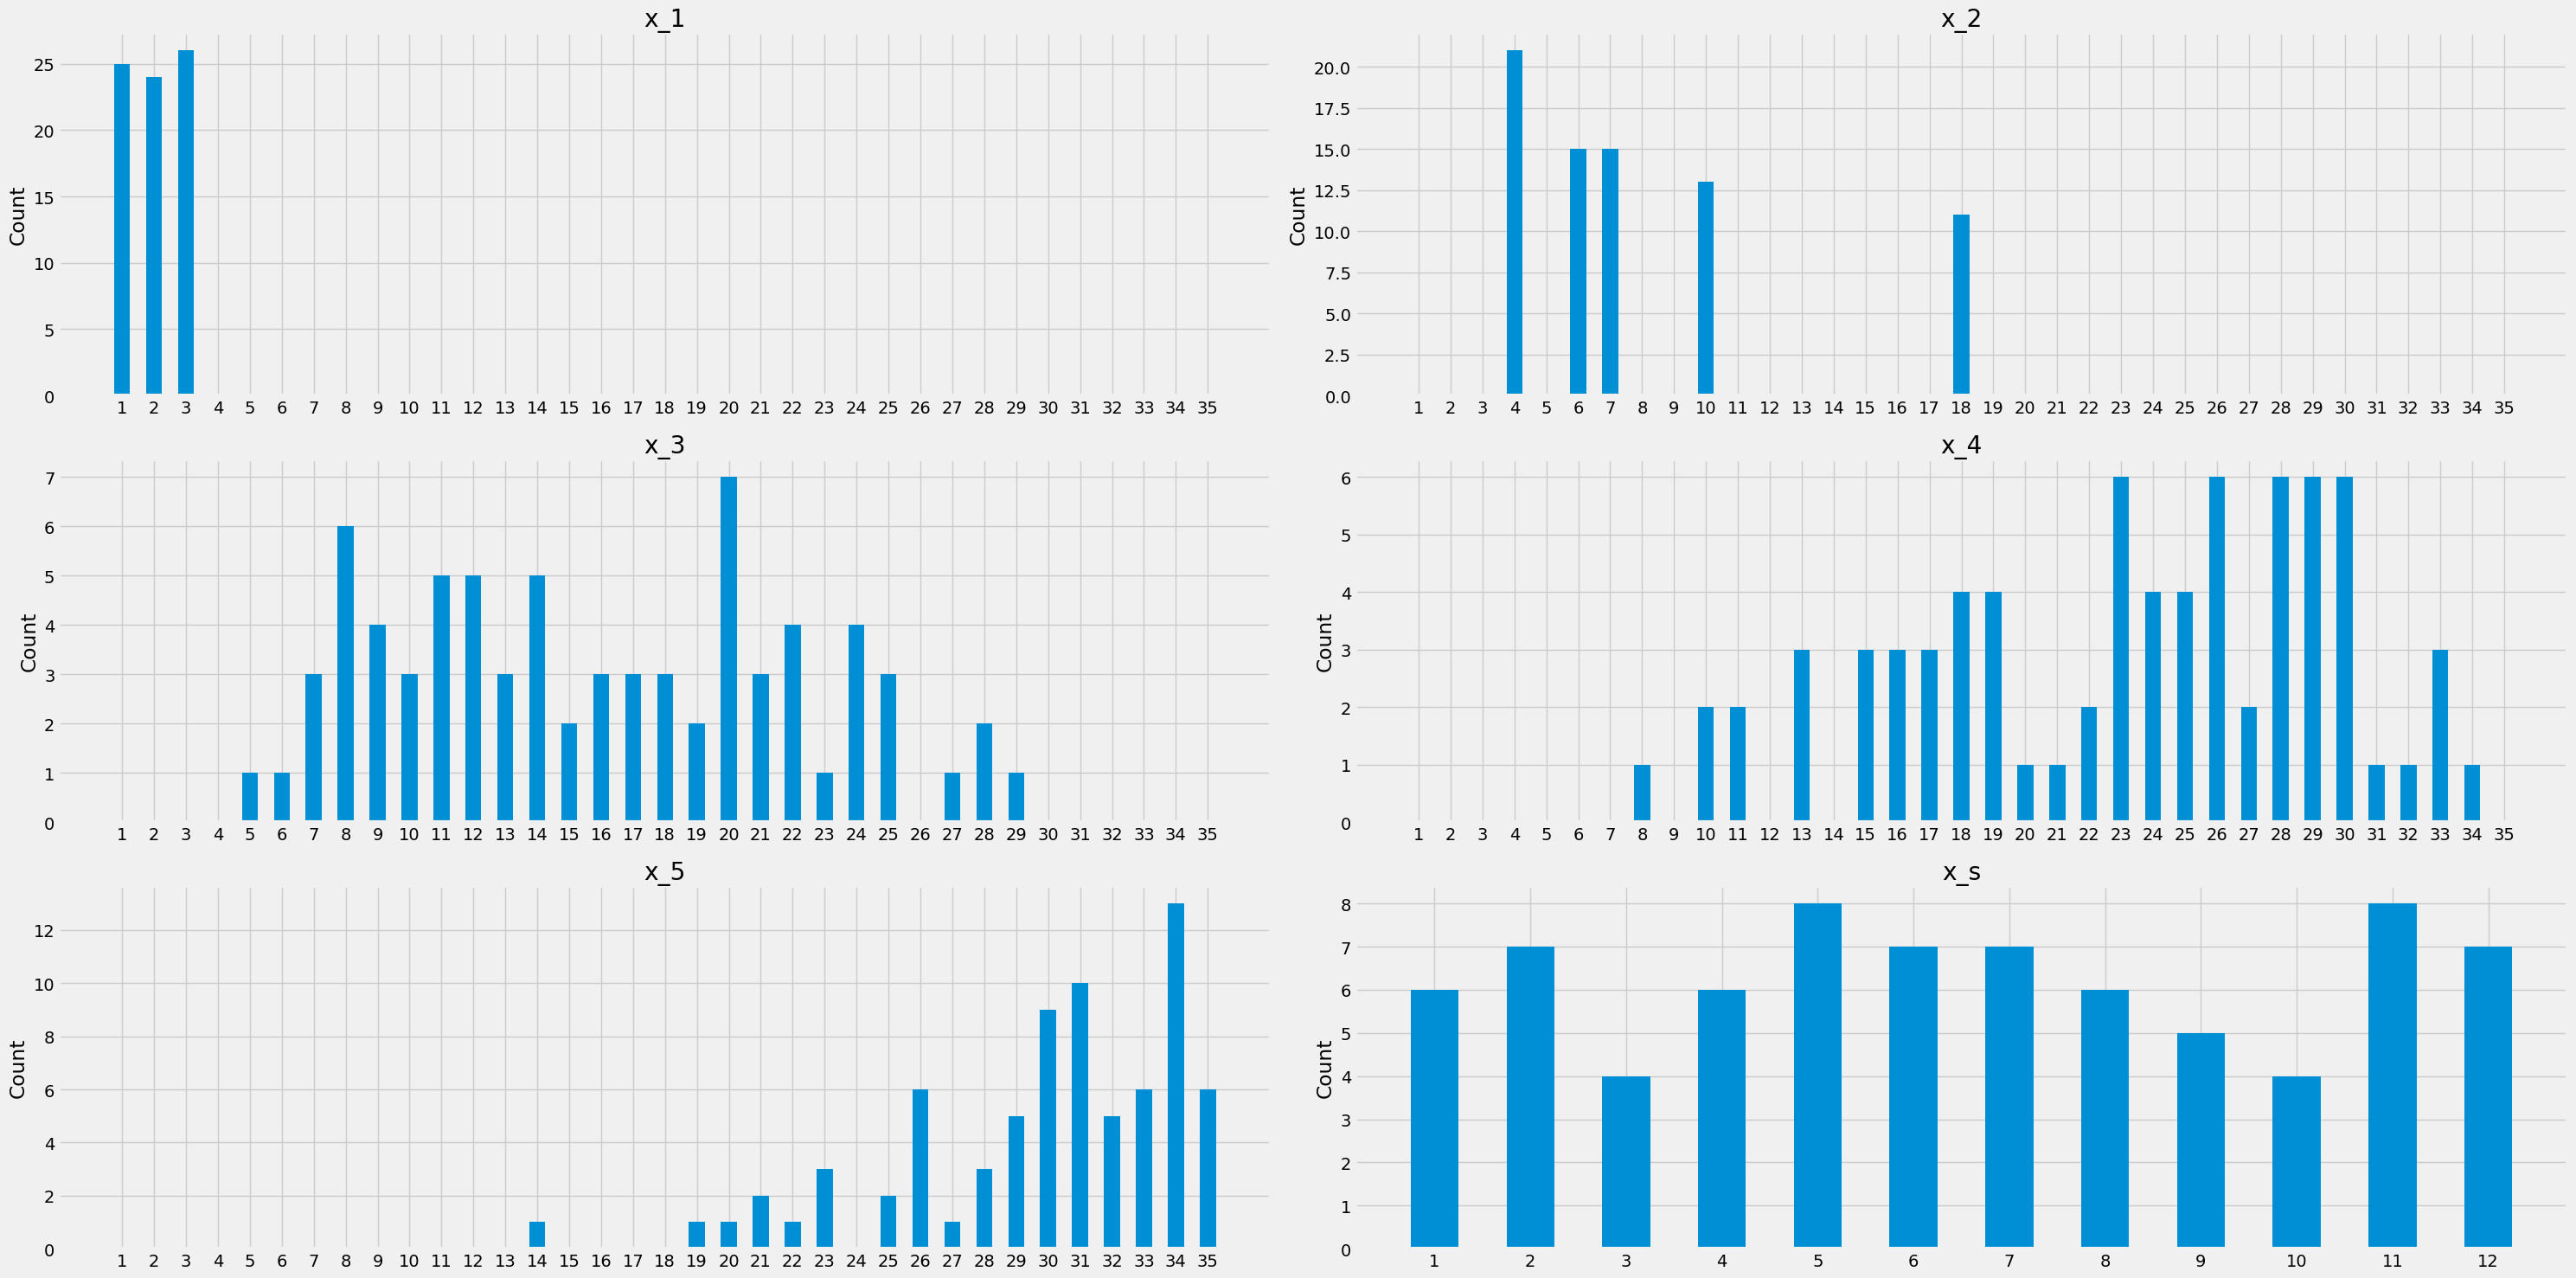

In [64]:
filter_2 = cleaned_df[
    cleaned_df["x_1"].isin(range(1, 4)) & cleaned_df["x_2"].isin([4, 6, 7, 10, 18])
]

plot_histograms(filter_2, mode="count")

In [63]:
extended_summary(filter_2["x_3"])

,x_3
Count,75.000000
Mean,15.840000
Median,15.000000
Mode,20.000000
Std Dev,6.253734
Variance,39.109189
Min,5.000000
Max,29.000000
Skewness,0.229418
Kurtosis,-1.003573


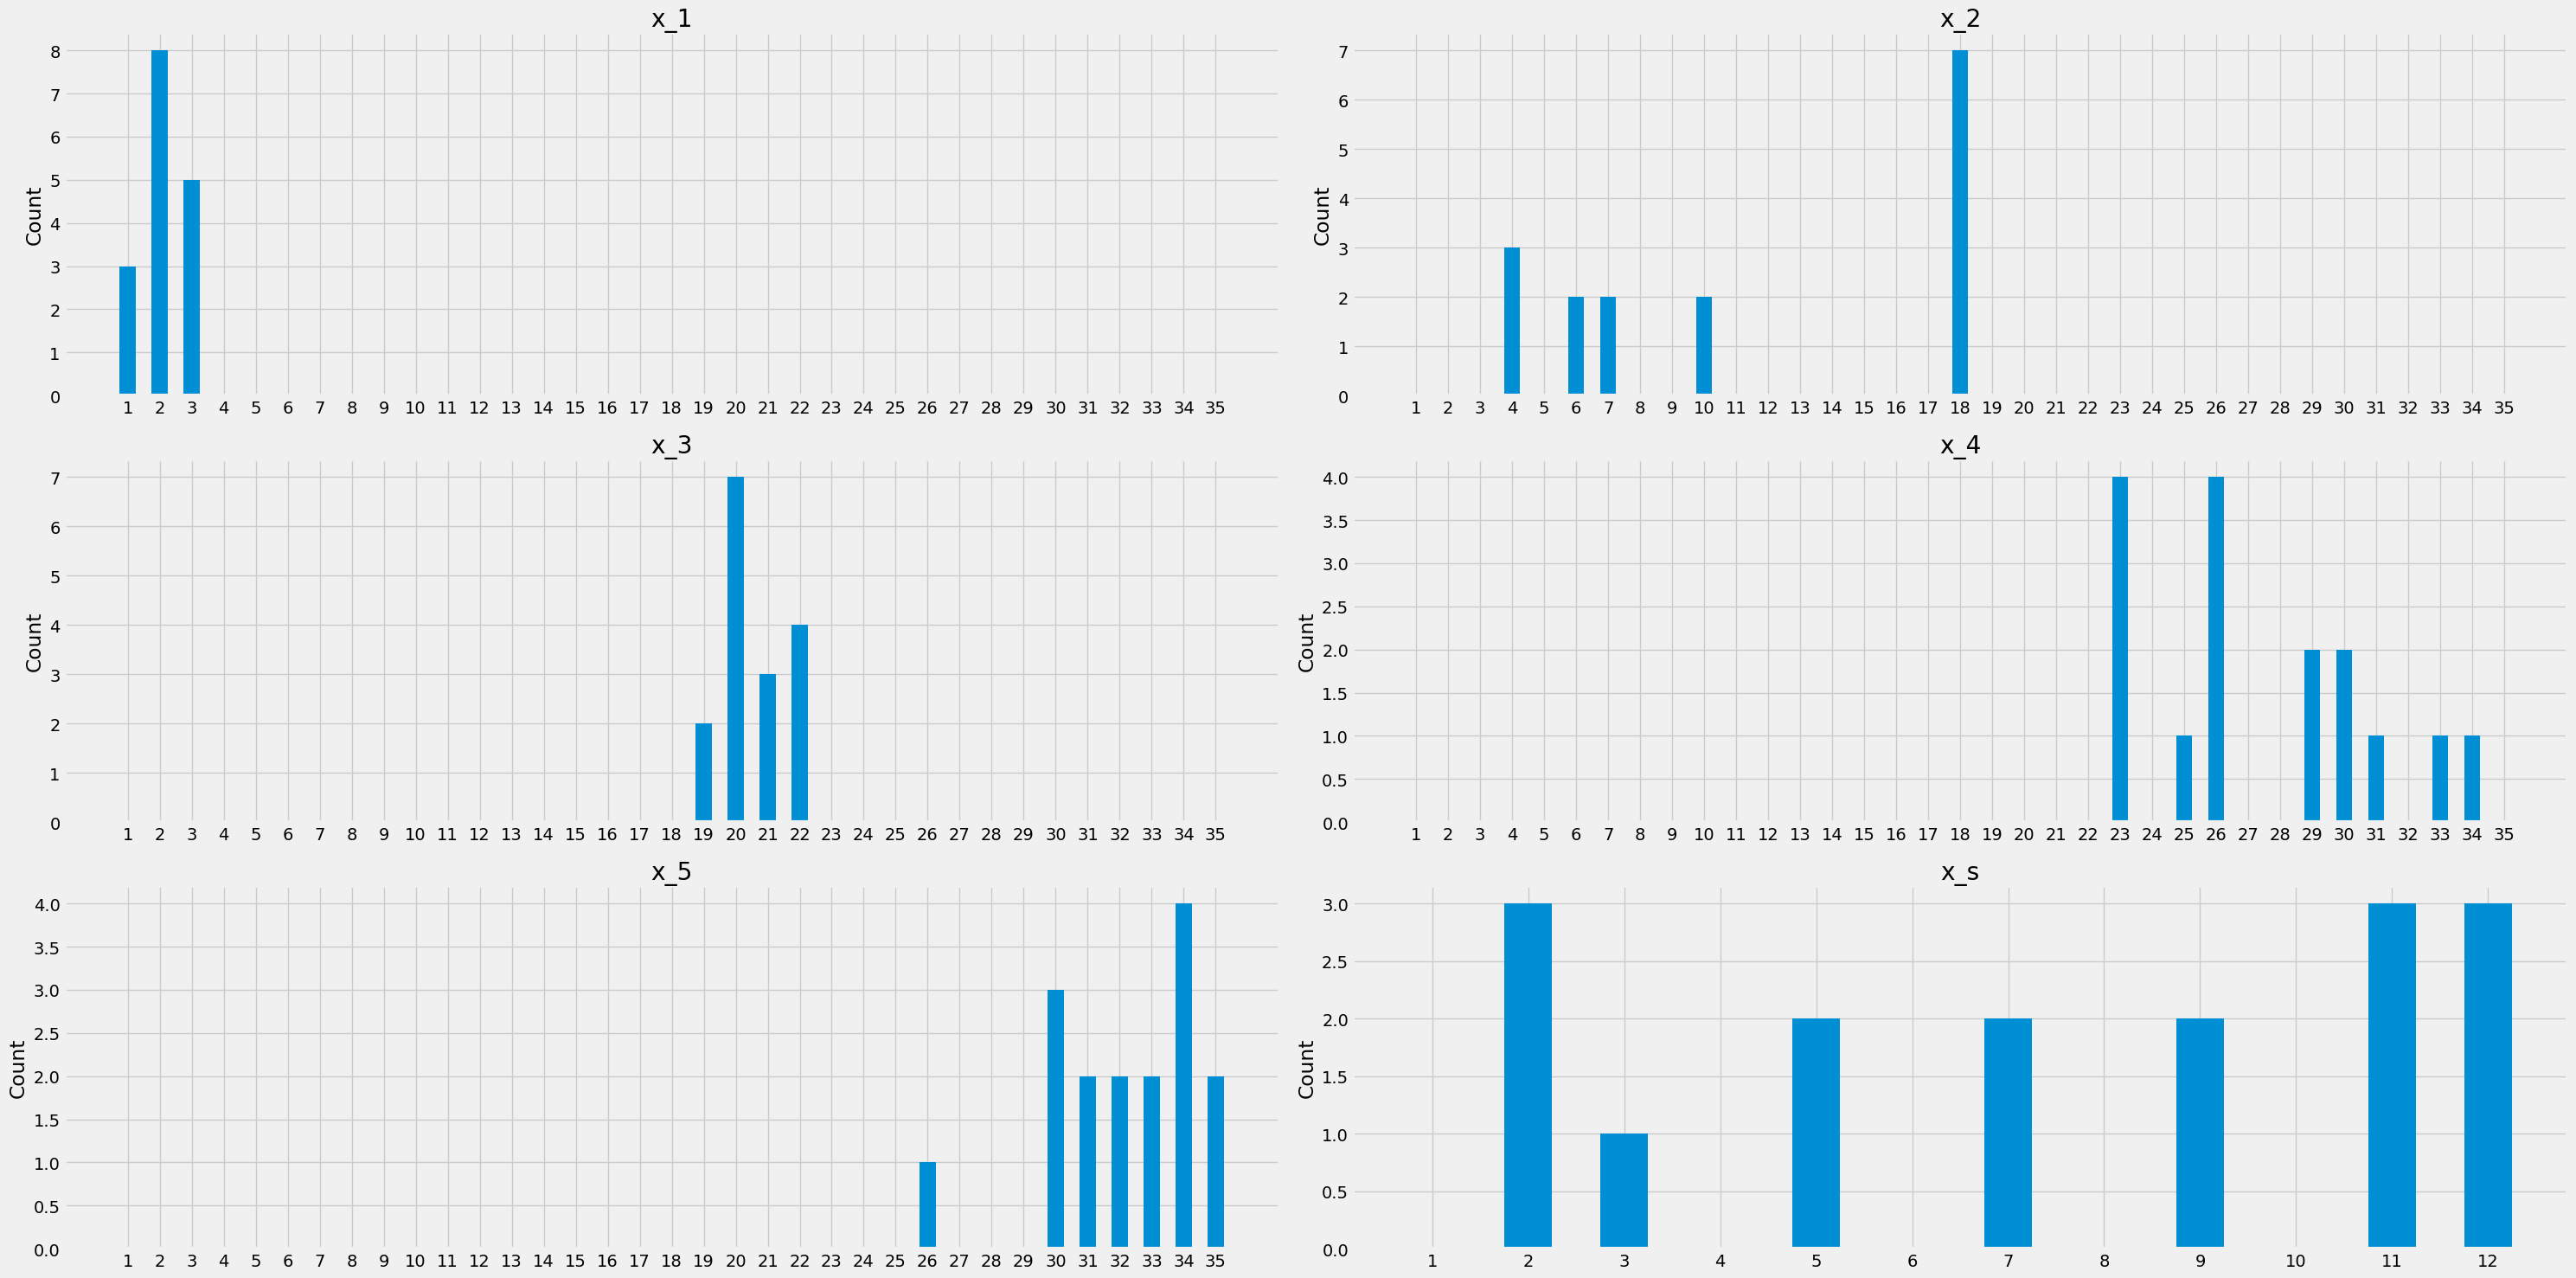

In [66]:
filter_3 = cleaned_df[
    cleaned_df["x_1"].isin(range(1, 4))
    & cleaned_df["x_2"].isin([4, 6, 7, 10, 18])
    & cleaned_df["x_3"].isin([19, 20, 21, 22])
]

plot_histograms(filter_3, mode="count")

In [67]:
extended_summary(filter_3["x_4"])

,x_4
Count,16.000000
Mean,27.312500
Median,26.000000
Mode,23.000000
Std Dev,3.628016
Variance,13.162500
Min,23.000000
Max,34.000000
Skewness,0.381982
Kurtosis,-0.962262


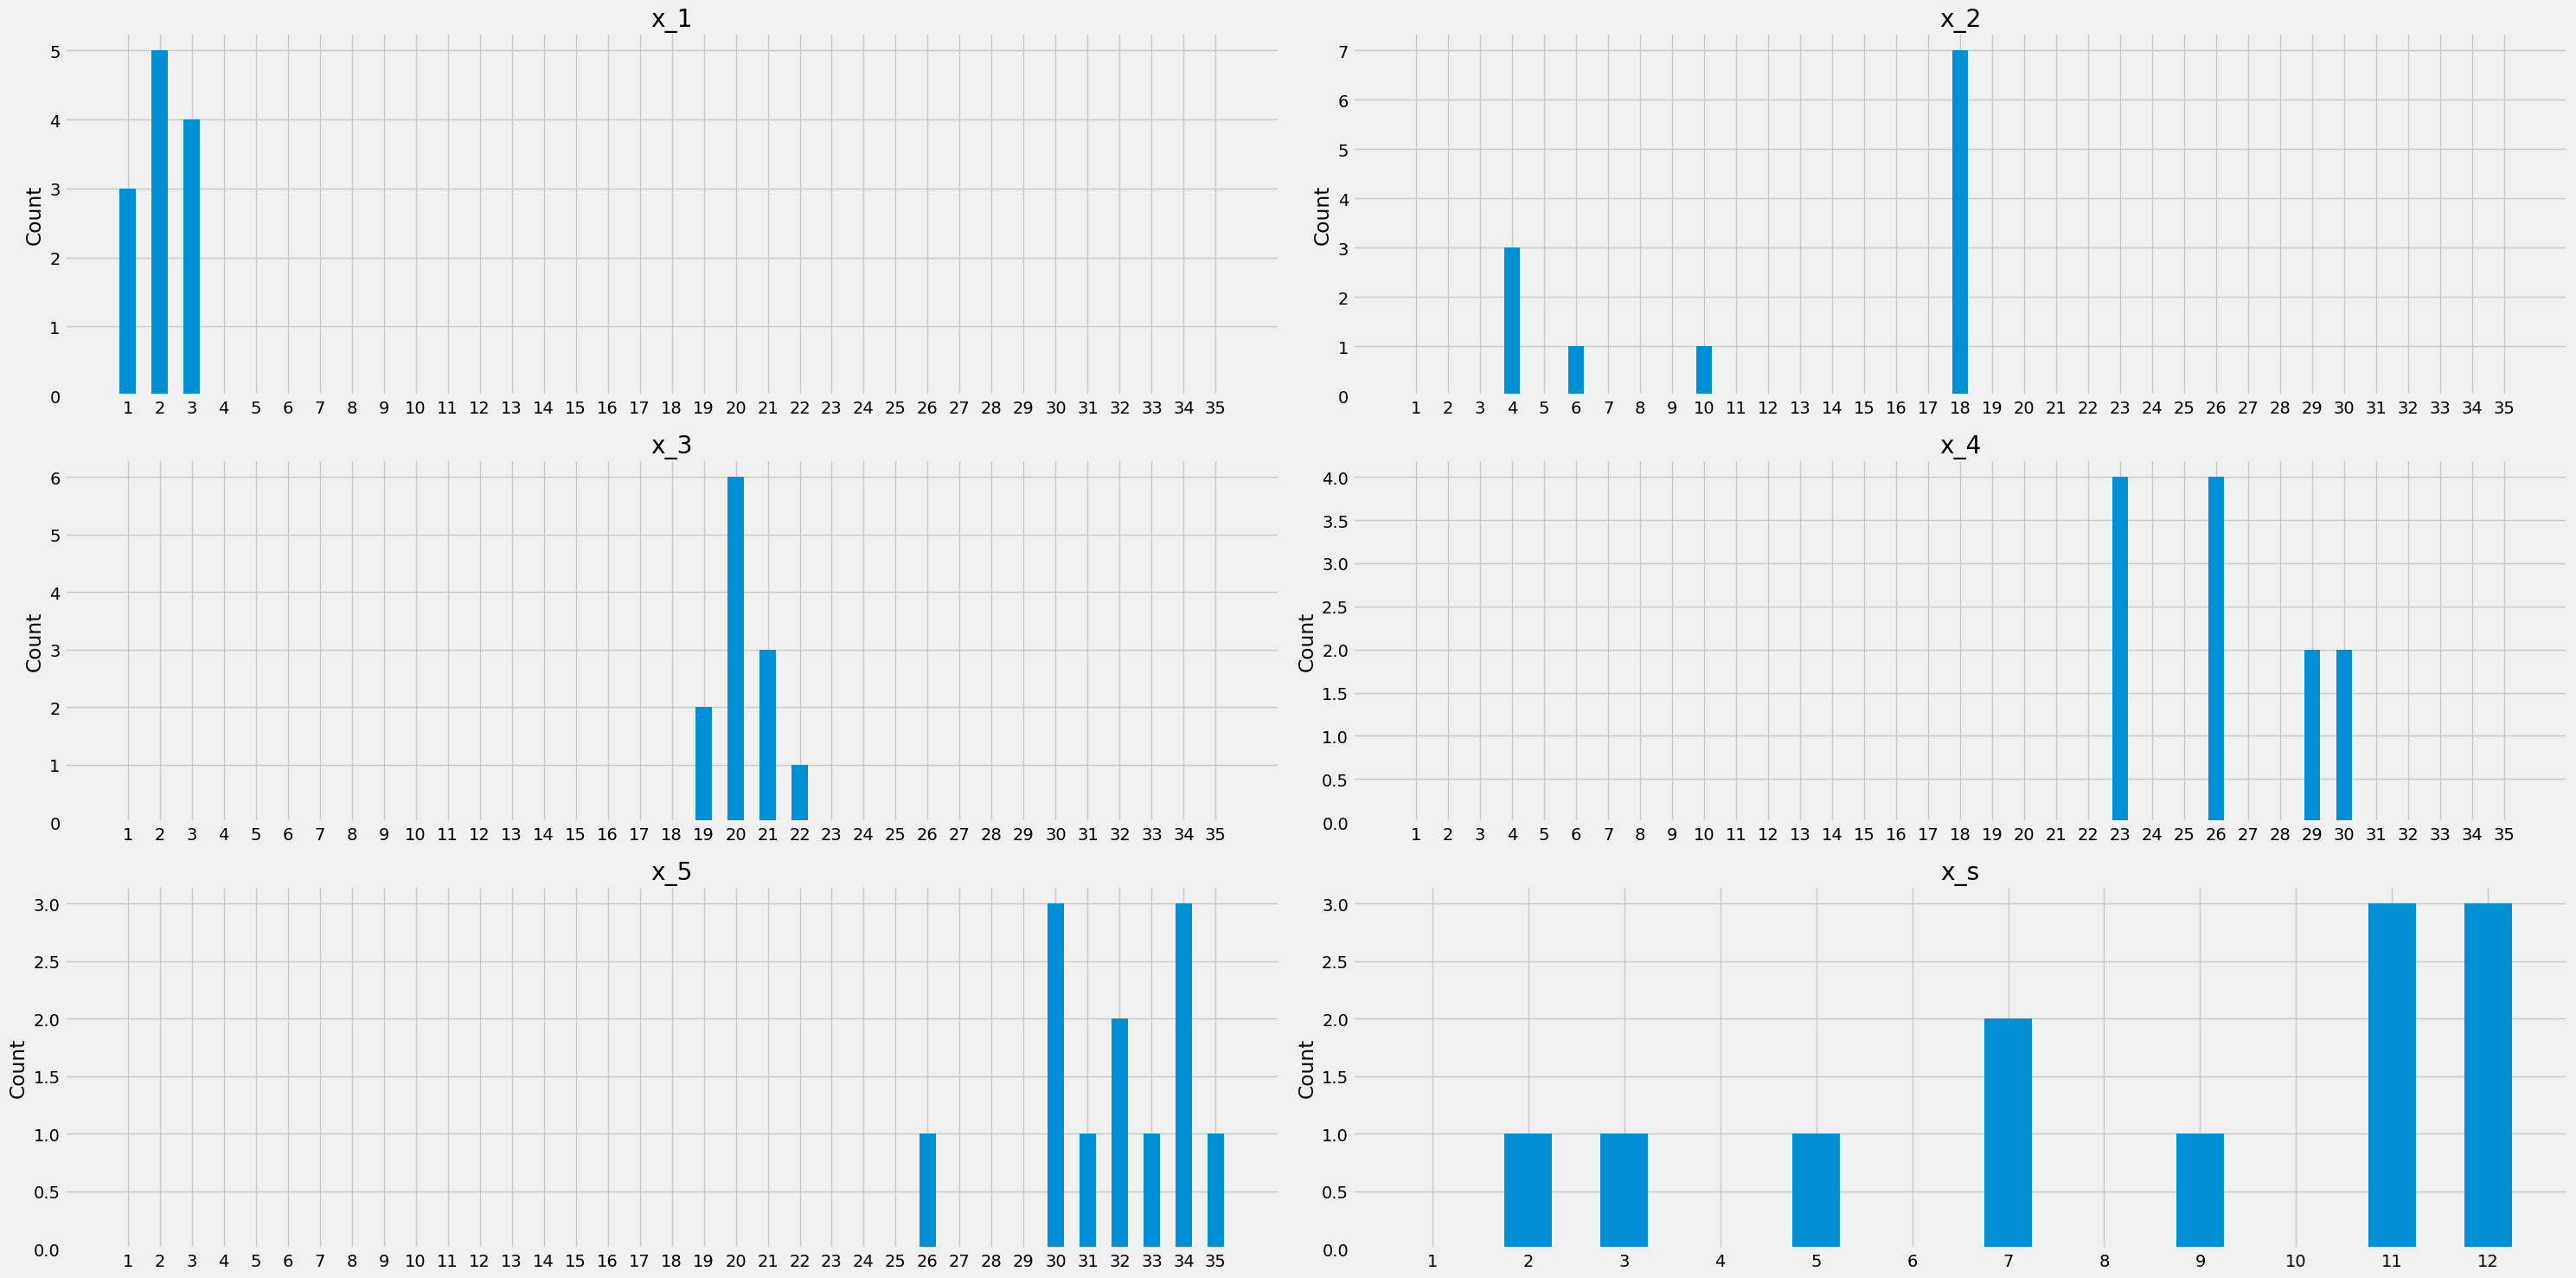

In [72]:
filter_4 = cleaned_df[
    cleaned_df["x_1"].isin(range(1, 4))
    & cleaned_df["x_2"].isin([4, 6, 7, 10, 18])
    & cleaned_df["x_3"].isin([19, 20, 21, 22])
    & cleaned_df["x_4"].isin([23, 26, 29, 30])
]

plot_histograms(filter_4, mode="count")

In [69]:
extended_summary(filter_4["x_5"])

,x_5
Count,12.000000
Mean,31.750000
Median,32.000000
Mode,30.000000
Std Dev,2.527126
Variance,6.386364
Min,26.000000
Max,35.000000
Skewness,-0.920123
Kurtosis,1.037464


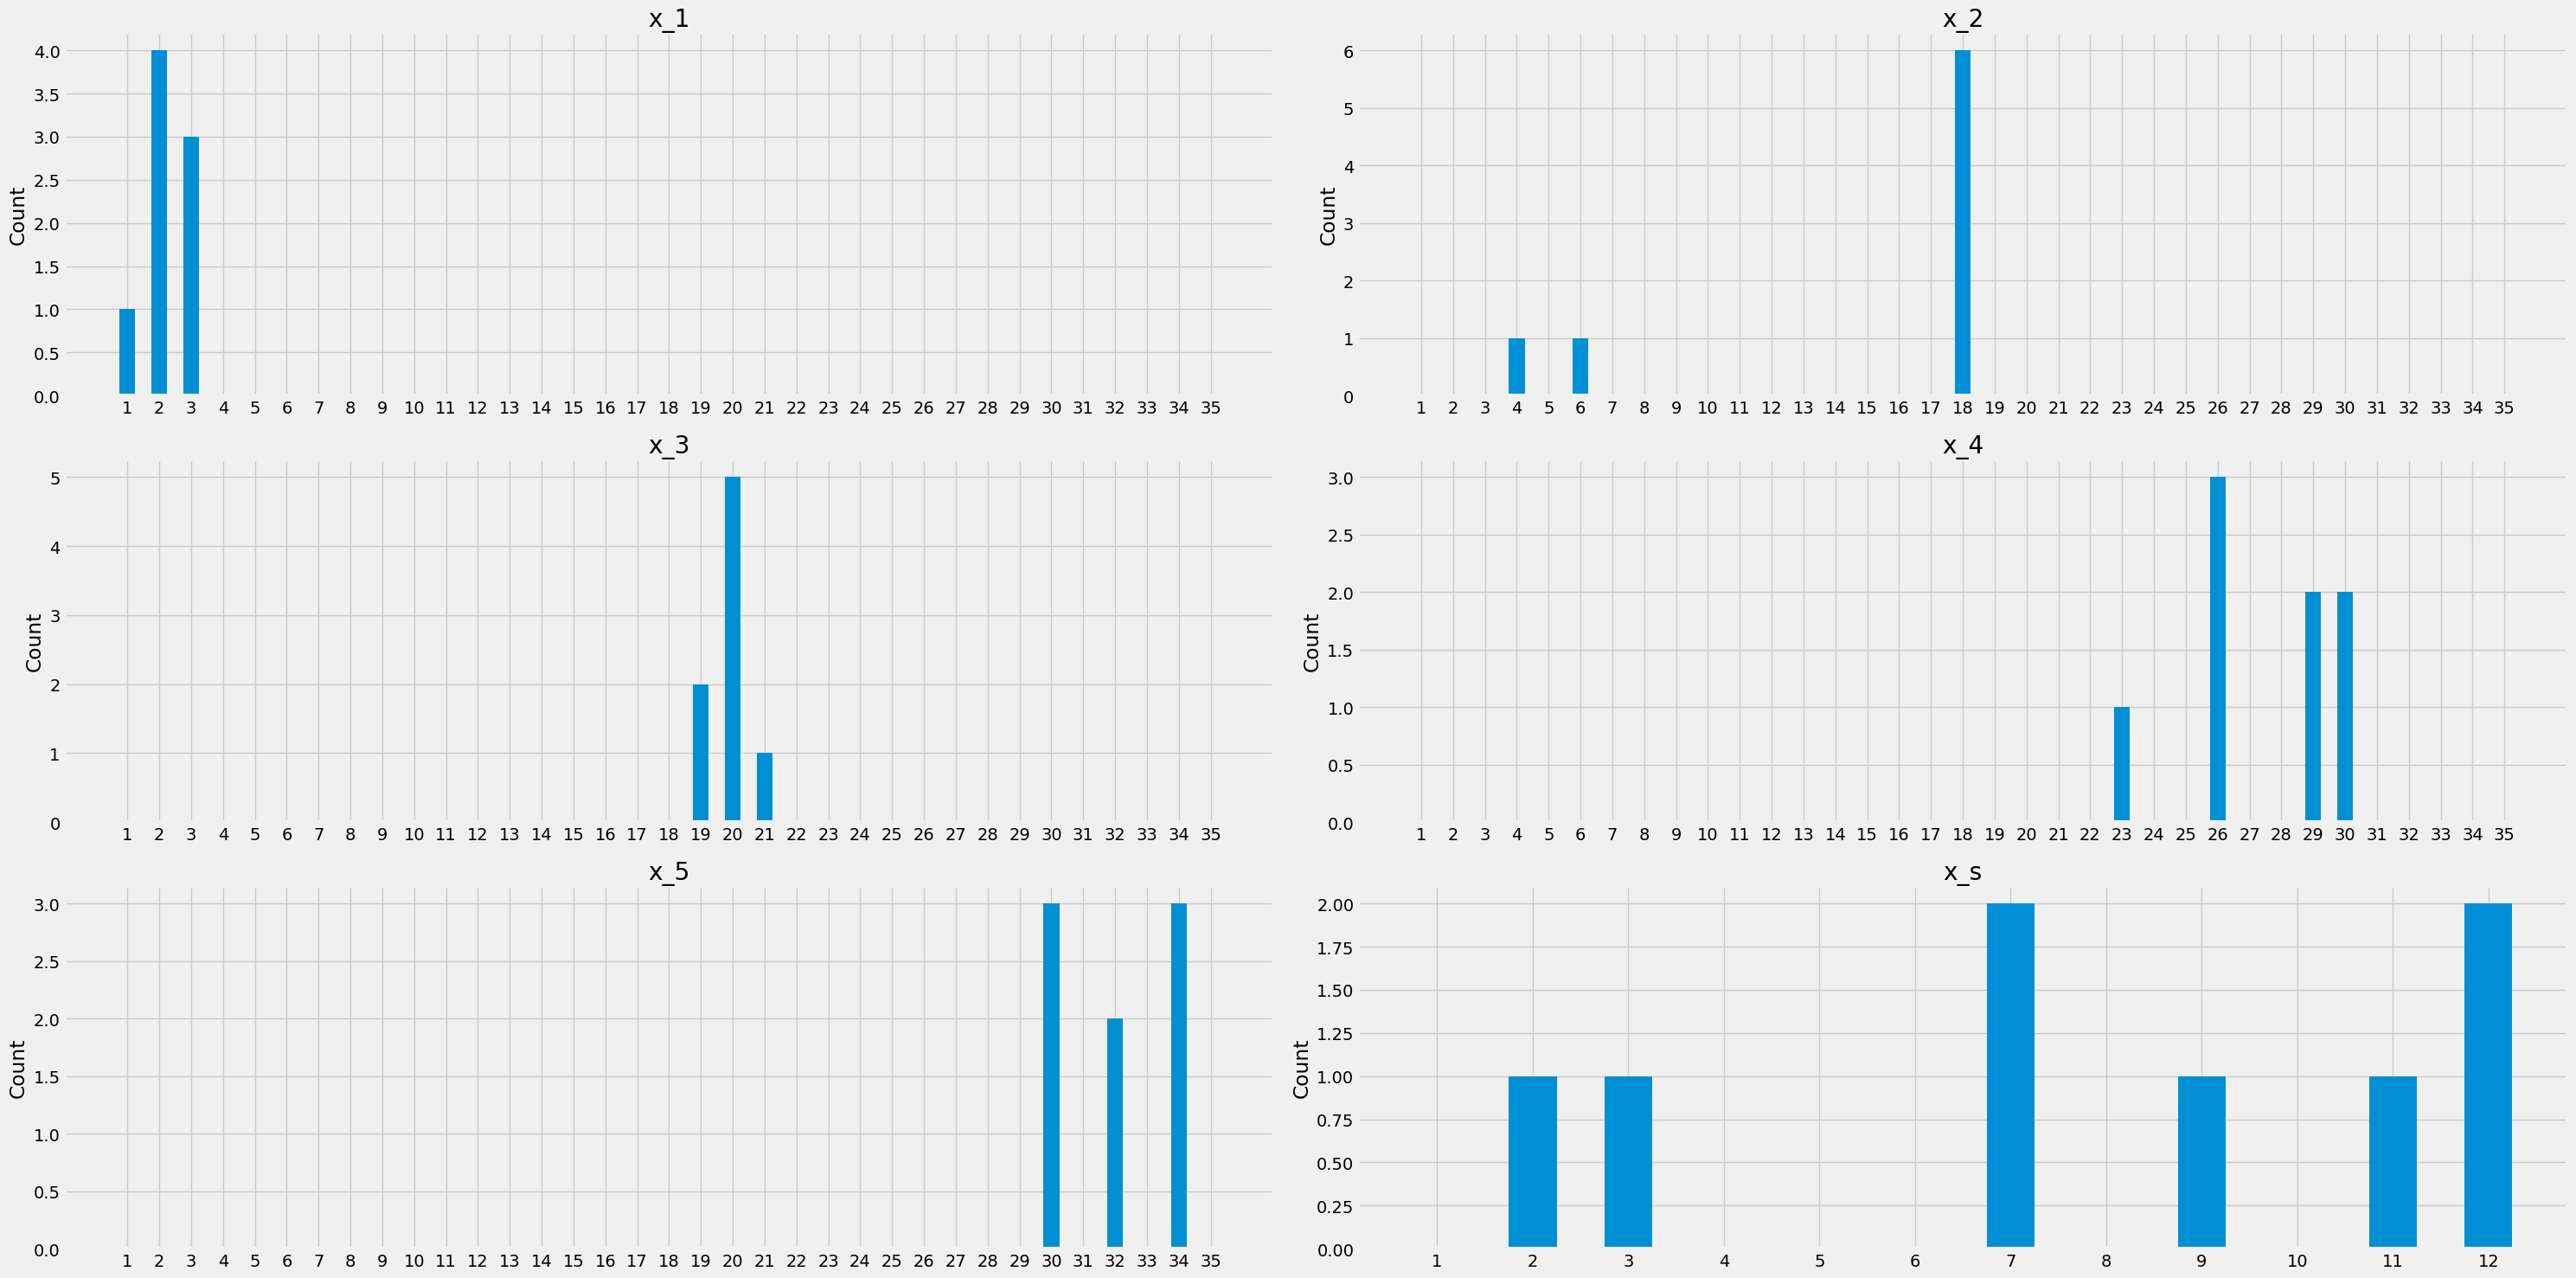

In [73]:
filter_5 = cleaned_df[
    cleaned_df["x_1"].isin(range(1, 4))
    & cleaned_df["x_2"].isin([4, 6, 7, 10, 18])
    & cleaned_df["x_3"].isin([19, 20, 21, 22])
    & cleaned_df["x_4"].isin([23, 26, 29, 30])
    & cleaned_df["x_5"].isin([30, 32, 34])
]

plot_histograms(filter_5, mode="count")

### Create permutation

In [ ]:
def create_ordered_permutations(ranges_dict):
    keys = list(ranges_dict.keys())
    values = list(ranges_dict.values())

    # Generate Cartesian product
    permutations = itertools.product(*values)

    # Keep only strictly increasing rows (no duplicates automatically)
    filtered = [
        p for p in permutations if all(p[i] < p[i + 1] for i in range(len(p) - 1))
    ]

    return pd.DataFrame(filtered, columns=keys)

In [74]:
ranges = {
    "x_1": [1, 2, 3],
    "x_2": [4, 6, 7, 10, 18],
    "x_3": [19, 20, 21, 22],
    "x_4": [23, 26, 29, 30],
    "x_5": [30, 32, 34],
}

In [78]:
output_df = create_ordered_permutations(ranges)
output_df

,x_1,x_2,x_3,x_4,x_5
0,1,4,19,23,30
1,1,4,19,23,32
2,1,4,19,23,34
3,1,4,19,26,30
4,1,4,19,26,32
...,...,...,...,...,...
655,3,18,22,29,30
656,3,18,22,29,32
657,3,18,22,29,34
658,3,18,22,30,32
